# Deep Art Gallery
> Neural Style Transfer, ConvNet(VGG19), Transfer Learning, tf-gpu

- toc: true
- branch: master
- badges: true
- comments: true
- author: Jaekang Lee
- categories: [fastpages, jupyter,meme]

<img src="images/res/generated_image (1).jpg" style="width:400px;height:300px;">
<center>This is me when I went to Aachen</center>
<img src="images/res/generated_image (2).jpg" style="width:400px;height:300px;">
<img src="images/res/generated_image (3).jpg" style="width:400px;height:300px;">
<center>This is Coquitlam, Canada where I spent my high school years! We used to be forced to do laps around this lake!</center>
<img src="images/res/generated_image.jpg" style="width:400px;height:300px;">
<img src="images/res/generated_image (4).jpg" style="width:400px;height:300px;">
<img src="images/res/generated_image (5).jpg" style="width:400px;height:300px;">
<img src="images/res/generated_image (7).jpg" style="width:400px;height:300px;">
<center>This is meemaw. </center>
<img src="images/res/generated_image (8).jpg" style="width:400px;height:300px;">
<img src="images/res/generated_image (9).jpg" style="width:400px;height:300px;">
<img src="images/res/generated_image (10).jpg" style="width:400px;height:300px;">
<center>This was outside my room in Toronto and when I was high</center>
<img src="images/res/tru.png" style="width:400px;height:300px;">
<center>This is my handsome friend Truman Hung!</center>
<img src="images/res/200.jpg" style="width:400px;height:300px;">
<center>It has no idea what to do with my hair lol</center>

## Styles used

<img src="images/style.png" style="width:1600px;height:600px;">
I think you can guess which styles were used on which photos : )

## How it works

Neural Style Transfer works by choosing a content image and a style image and then 'drawing' the content image using style of the style image.

In implementation, all we are doing is calculating some derivatives to make a number small as possible. 

This is the cost function we are trying to minimize. As $J(GeneratedImage)$ gets smaller, we get the art we want. Think of cost function as distance from our art being beautiful. G is initialized as a random noise image. We will use Adam optimization to compute the gradient. Think of gradient as small step towards prettiness.

<img src="images/1.png" style="width:800px;height:300px;">

So every iteration, G will be subtracted with gradient of $J(GeneratedImage)$ slowly becoming beautiful.

<img src="images/2.png" style="width:800px;height:400px;">

#### Content Cost Function $J_{content}(C,G)$

$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1} $$

* Here, $a$ stands for activation of the lth layer in our convNet. 
* $n_H$, $n_W$, $n_C$ is the dimension of the layer. (Height, width, depth).
* The constants in front are just for normalization.


#### Style Cost Function $J_{style}(S,G)$
$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{(gram)i,j} - G^{(G)}_{(gram)i,j})^2\tag{2} $$

* The constants in front are just for normalization
* The gram is a function that just calculates the correlation between horizontal vectors in the given matrix(which is our depths)
* We will calculate gram of activation layer from both content and generated layer for all combinations of depths(i,j).
* And this is just one layer. Then we compute for all layers. This is why it takes so long to generate our image.
* Note that the picture below 'unrolled' a 3d volume into 2d matrix.
<img src="images/3.png" style="width:9000px;height:300px;">
* As you can see style cost function is less straightforward. "If you don't understand it, don't worry about it" - Andrew NG.

### Code
Read Reference

In [1]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import PIL.Image
from nst_utils import *
import numpy as np
import tensorflow as tf
import pprint
%matplotlib inline
from IPython import display
import imageio

In [2]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

In [3]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img


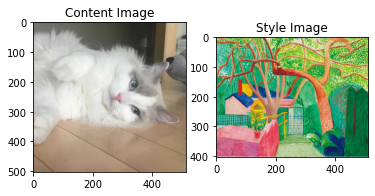

In [9]:
content_image = load_img('images/eggie.jpg')
style_image = load_img('images/hockney.jpg')
plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

In [10]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

## Transfer Learning

Choice for the model is VGG19 since it is what was used in the original paper by Leon A. Gatys, Alexander S. Ecker, Matthias Bethge.

In [11]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [12]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [13]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
# for name, output in zip(style_layers, style_outputs):
#   print(name)
#   print("  shape: ", output.numpy().shape)
#   print("  min: ", output.numpy().min())
#   print("  max: ", output.numpy().max())
#   print("  mean: ", output.numpy().mean())
#   print()

### Helper functions

In [14]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [15]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content':content_dict, 'style':style_dict}

In [16]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

# print('Styles:')
# for name, output in sorted(results['style'].items()):
#   print("  ", name)
#   print("    shape: ", output.numpy().shape)
#   print("    min: ", output.numpy().min())
#   print("    max: ", output.numpy().max())
#   print("    mean: ", output.numpy().mean())
#   print()

# print("Contents:")
# for name, output in sorted(results['content'].items()):
#   print("  ", name)
#   print("    shape: ", output.numpy().shape)
#   print("    min: ", output.numpy().min())
#   print("    max: ", output.numpy().max())
#   print("    mean: ", output.numpy().mean())

In [17]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [18]:
image = tf.Variable(content_image)

In [19]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [20]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [21]:
style_weight=1e-2
content_weight=1e4

In [22]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [23]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

## Training

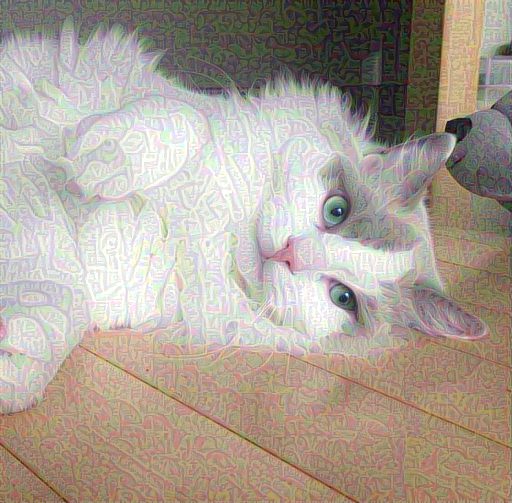

In [24]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

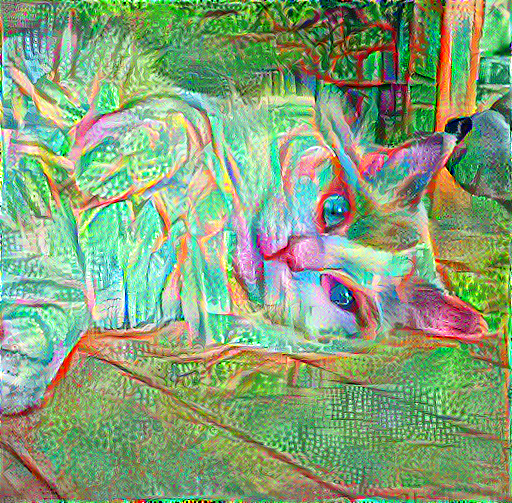

Train step: 1000
Total time: 813.6


In [25]:
import time
with tf.device("/gpu:0"):
    start = time.time()
    epochs = 10
    steps_per_epoch = 100

    step = 0
    for n in range(epochs):
      for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
      display.clear_output(wait=True)
      display.display(tensor_to_image(image))
      print("Train step: {}".format(step))
    
      # save current generated image in the "/output" directory
      imageio.imwrite("output/" + str(2*100) + ".png", tensor_to_image(image))

    
    end = time.time()
    print("Total time: {:.1f}".format(end-start))

In [26]:
# save_image("output/" + str(2*100) + ".png", tensor_to_image(image))
imageio.imwrite("output/" + str(2*100) + ".png", tensor_to_image(image))

## Total Variation Loss
I didn't learn this part its like magic to me

In [27]:
def high_pass_x_y(image):
  x_var = image[:,:,1:,:] - image[:,:,:-1,:]
  y_var = image[:,1:,:,:] - image[:,:-1,:,:]

  return x_var, y_var

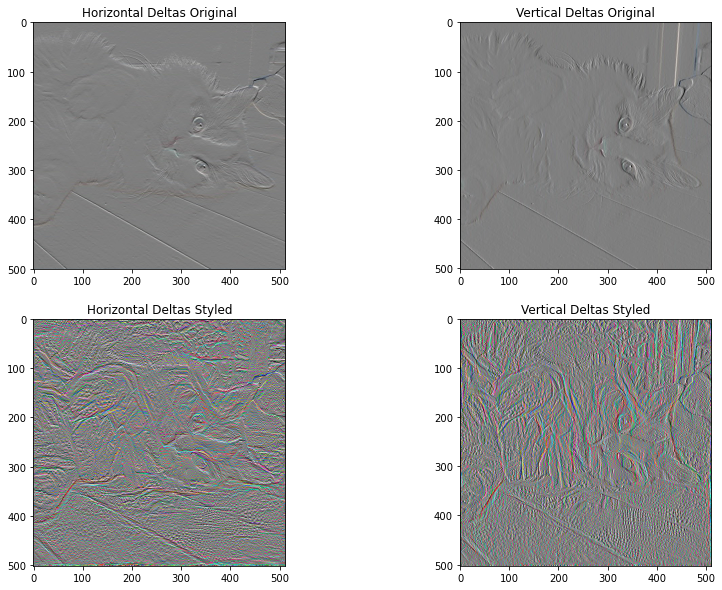

In [28]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas Original")

plt.subplot(2,2,2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2,2,3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas Styled")

plt.subplot(2,2,4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas Styled")

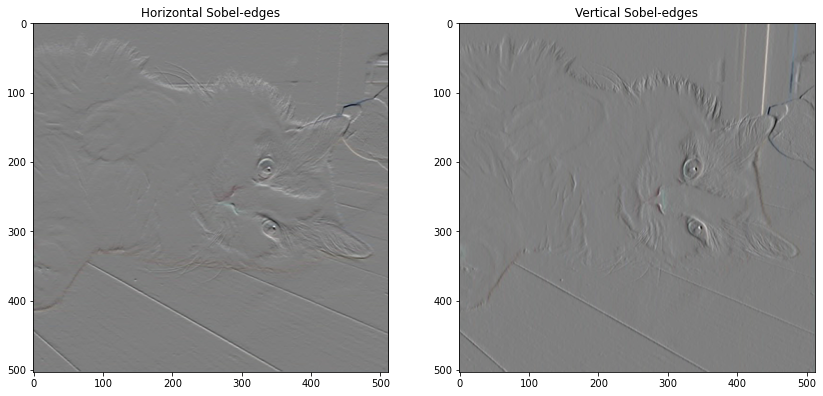

In [29]:
plt.figure(figsize=(14,10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1,2,1)
imshow(clip_0_1(sobel[...,0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1,2,2)
imshow(clip_0_1(sobel[...,1]/4+0.5), "Vertical Sobel-edges")

In [30]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [31]:
tf.image.total_variation(image).numpy()

array([160681.62], dtype=float32)

In [32]:
total_variation_weight=30

In [33]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [34]:
image = tf.Variable(content_image)

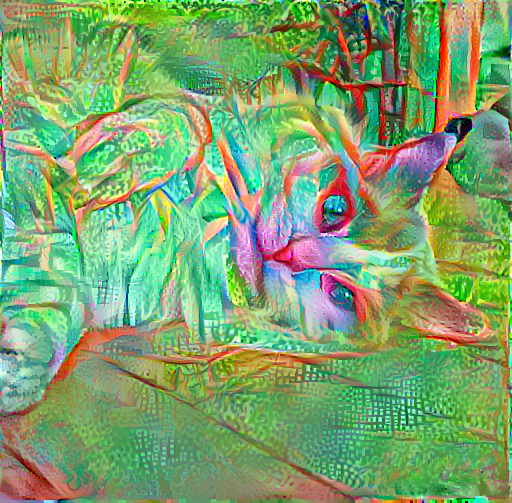

Train step: 1000
Total time: 1511.1


In [35]:
import time
with tf.device("/gpu:0"):
    start = time.time()

    epochs = 10
    steps_per_epoch = 100

    step = 0
    for n in range(epochs):
      for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
      display.clear_output(wait=True)
      display.display(tensor_to_image(image))
      print("Train step: {}".format(step))

    end = time.time()
    print("Total time: {:.1f}".format(end-start))

In [36]:
file_name = 'generated_image.png'
imageio.imwrite("output/" + 'generated_image' + ".png", tensor_to_image(image))

### References:

The Neural Style Transfer algorithm was due to Gatys et al. (2015). The pre-trained network used in this implementation is a VGG network, which is due to Simonyan and Zisserman (2015). The whole code is basically from tensorflow website listed below with little changes.

- Leon A. Gatys, Alexander S. Ecker, Matthias Bethge, (2015). [A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576) 
- Harish Narayanan, [Convolutional neural networks for artistic style transfer.](https://harishnarayanan.org/writing/artistic-style-transfer/)
- DeepLearningAi(Coursera) (2020). [Deep Learning Specialization](https://www.coursera.org/)
- TensorFlow (2019). [Neural style transfer](https://www.tensorflow.org/tutorials/generative/style_transfer)

